# old version

In [1]:
import os
import json
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" # so the IDs match nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # "0, 1" for multiple

import tensorflow as tf

In [3]:
INPUT_SHAPE = (512,256,3)
CLASS_NUMS = 4

In [4]:
def imread(path):
    im = cv2.imread(path)
    if im is None:
        return None
    
    im = im/255
    
    im_pad = np.zeros(INPUT_SHAPE,dtype=np.float64)
    h,w = im.shape[:2]
    if h/w > INPUT_SHAPE[0]/INPUT_SHAPE[1]:
        re_h = INPUT_SHAPE[0]
        re_w = int(w * (re_h / h))
    else:
        re_w = INPUT_SHAPE[1]
        re_h = int(h * (re_w / w))
    re_im = cv2.resize(im,(re_w,re_h))
    im_pad[:re_h,:re_w,:] = re_im.copy()
    return im_pad

In [5]:
def build_model(architecture='res50'):
    if architecture == 'res50':
        resnet_model = tf.keras.applications.resnet50.ResNet50(include_top=False,
                                weights='imagenet',input_shape=INPUT_SHAPE,pooling='avg')
        resnet_output = resnet_model.output

        resnet_input = resnet_model.input
#     elif architecture == 'res101':
#         resnet_input = tf.keras.Input((None,None,3))
#         _,_,_,_,C5 = resnet_graph(resnet_input,"resnet101")
#         resnet_output = tf.keras.layers.GlobalAveragePooling2D()(C5)

    output = tf.keras.layers.Dense(CLASS_NUMS,activation='softmax',name='fc_softmax')(resnet_output)

    sm_model = tf.keras.models.Model(inputs = resnet_input,outputs = output, name = 'res50_softmax')
    
    return sm_model

In [11]:
im_dir = '../dataset/bodytype/image_women/'
dataversion = 'v2'
train_json = '../dataset/bodytype/women_'+dataversion+'_train.json'
val_json = '../dataset/bodytype/women_'+dataversion+'_val.json'

In [12]:
if dataversion == 'v1':
    class_ids_dict = {0:u"Thin",1:u"Nomal",2:u"Fat",3:u"Fater"}
    model_path = './old_logs/20180801T1101_res50_momentum/ep_0094.h5'
if dataversion == 'v2':
    class_ids_dict = {0:u"yHourglass",1:u"yPear",2:u"yApple",3:u"yBanana"}
    model_path = './old_logs/20180902T1520_res50_adam_v2/ep_0020.h5'

In [13]:
f = open(train_json,'r')
train_infos = json.load(f)
f.close()
f = open(val_json,'r')
val_infos = json.load(f)
f.close()

In [14]:
architecture = 'res50'
model = build_model(architecture=architecture)
if model_path is not None:
    model.load_weights(model_path,by_name=True)

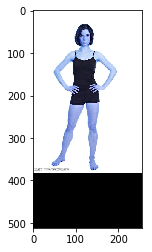

0 yHourglass
yHourglass 0.315711
yPear 0.3089312
yApple 0.17663372
yBanana 0.19872408


In [31]:
im = imread('../dataset/bodytype/test_im/4.jpg')
plt.imshow(im)
plt.show()
im = np.array([im])
res = model.predict(im)
ress = np.argmax(res)
print(ress,class_ids_dict[ress])
for i,con in enumerate(res[0]):
    print(class_ids_dict[i],con)

In [12]:
tr = 0
fa = 0
cur_infos = val_infos
for name in cur_infos.keys():
    im = imread(os.path.join(im_dir,name))
    if im is None:
        continue
    im = np.array([im])
    res = model.predict(im)
    res = np.argmax(res)
    if res == cur_infos[name]['label']:
        tr += 1
    else:
        fa += 1
print(tr,fa,tr/(fa+tr))

KeyboardInterrupt: 

# new version

In [1]:
import os
import json
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" # so the IDs match nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # "0, 1" for multiple

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
tf.keras.backend.set_session(session)

In [3]:
from model import Model
from config import Config

In [4]:
model_dir = './logs/regress_surreal-human_20190109T1611/'
model_path = os.path.join(model_dir,'ep_0031.h5')
# model_dir = './logs/regress_up_20181205T0934'
# model_path = os.path.join(model_dir,'ep_0100.h5')
config_path = os.path.join(model_dir,'config.json')
model_config = Config(mode='eval')
model_config.set_config(config_path)
model_config.set_param(["MODEL_PATH"],[model_path])
model_config.show_config()


======set config from file=======
./logs/regress_surreal-human_20190109T1611/config.json

set MODEL_PATH to ./logs/regress_surreal-human_20190109T1611/ep_0031.h5

============== Param =============
===========>config mode eval
ARCHITECTURE : res50
INPUT_SHAPE : [240, 240, 3]
MODEL_NAME : regress
CLASS_NUMS : 4
BETA_NUMS : 10
POSE_NUMS : 72
MODEL_PATH : ./logs/regress_surreal-human_20190109T1611/ep_0031.h5



In [5]:
model = Model(model_config)

### eval by name

In [10]:
path = '../dataset/bodytype/test_human/400_0.jpg'

In [7]:
with open('../dataset/bodytype/SURREAL/val_names_sort.json') as f:
    val_info = json.load(f)
index = 57
path = os.path.join('../dataset/SURREAL/summary/human',val_info[index]+'.jpg')

In [9]:
im,res = model.eval_one_image(path)
print((res/100).tolist())
# print((res).tolist())

[0.4280887544155121, -0.5448428988456726, -1.2685611248016357, 0.49936988949775696, -0.13338293135166168, -0.4115179479122162, -0.4583273231983185, 0.7812883853912354, -0.5967003107070923, 1.113707184791565]


In [11]:
im,res = model.eval_one_image(path)
print((res/100).tolist())
# print((res).tolist())

[0.6131222248077393, -0.6587262153625488, -1.2424731254577637, 0.8103485107421875, -0.6837827563285828, -1.3132193088531494, -0.8398178815841675, 1.05488920211792, -1.2532695531845093, 1.606264591217041]


In [60]:
with open(os.path.join('../dataset/SURREAL/summary/labels/',val_info[index]+'.json')) as f:
    info = json.load(f)
    shape_res = info['shape']
    pose_res = info['pose']
print(shape_res)
print(pose_res)

NameError: name 'index' is not defined

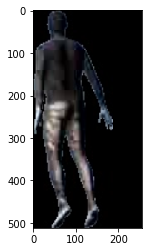

In [10]:
plt.imshow(im)
plt.show()

### eval by json

In [22]:
im_dir = '../dataset/bodytype/up-3d-mask-box/'
dataversion = 'up'
train_json = '../dataset/bodytype/dataset_'+dataversion+'_train.json'
val_json = '../dataset/bodytype/dataset_'+dataversion+'_val.json'

In [23]:
train_info = json.load(open(train_json,'r'))
val_info = json.load(open(val_json,'r'))

In [24]:
im_names = list(val_info.keys())

In [25]:
outputs = {}
json_outputs = {}
for i,name in enumerate(im_names):
    im_path = os.path.join(im_dir,name)
    im,res = model.eval_one_image(im_path)
    outputs[name] = {}
    outputs[name]['im'] = im
    outputs[name]['res'] = res/100
    json_outputs[name] = {}
    json_outputs[name]['betas'] = res.tolist()
    json_outputs[name]['pose'] = val_info[name]['pose']
    print(i+1,'/',len(im_names),end='\r')

In [26]:
output_json = os.path.join(model_dir,dataversion+'_val.json')
print(output_json)
f = open(output_json,'w')
f.write(json.dumps(json_outputs,indent=2))

./logs/regress_surreal-human_20190109T1611/up_val.json


1948618

### eval by im_dir

In [26]:
im_dir = '../dataset/SURREAL/summary/demo/image/'
label = '../dataset/SURREAL/summary/demo/label/'

In [9]:
im_names = os.listdir(im_dir)
outputs = model.eval_dir(im_dir)

show

In [23]:
index = 0

[0.4278925657272339, 0.22881928086280823, -0.013581468723714352, -0.24310103058815002, -0.04215279221534729, -0.008882051333785057, 0.04243890196084976, 0.012448607943952084, 0.0062517570331692696, -0.013385254889726639]
[1.2073696851730347, -0.8507285714149475, -1.1292041540145874, -0.9510261416435242, 0.07789754867553711, 0.5159295797348022, -0.9077296853065491, -0.2702786922454834, -0.5215744376182556, 0.9025160074234009, 0.07421822100877762, -0.014276993460953236, 1.9255598783493042, -0.040648460388183594, -0.39463338255882263, 2.0935378074645996, -0.18728935718536377, 0.3204759359359741, -0.29335376620292664, 0.014666341245174408, 0.036402732133865356, -0.3738151788711548, 0.15037158131599426, -0.1269879937171936, -0.24398471415042877, 0.10992898046970367, 0.3297092616558075, -0.03581778705120087, 0.0750771313905716, 0.04646219685673714, -0.3130025565624237, -0.030022259801626205, 0.2630772888660431, -0.2750321328639984, -0.18431304395198822, -0.32002708315849304, -0.0616757124662

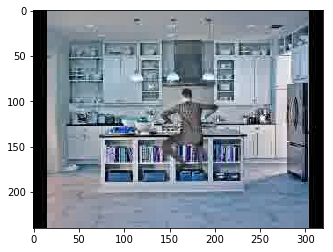

In [31]:
key = list(outputs.keys())[index]
im = cv2.imread(os.path.join(im_dir,key))
res = outputs[key]['res']
f = open(os.path.join(label,key[:-4]+'.json'),'r')
info = json.load(f)
f.close()
print(res.tolist())
print(info['pose'])
print(info['shape'])
plt.imshow(im)
plt.show()
index += 1

save

In [32]:
output_dir = './eval/demo'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
for key in outputs.keys():
    im = outputs[key]['im']
    res = outputs[key]['res']
    base_name = key[:-4]
    f = open(os.path.join(output_dir,base_name+'.json'),'w')
    f.write(json.dumps(res.tolist()))
    f.close()

### res analysis

---
pre need run eval by im_dir or json

#### one image analysis

In [27]:
index = 1

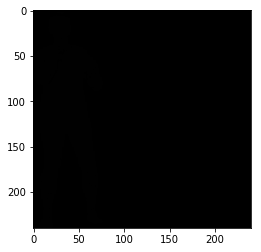

[ 0.32880512  0.3335984  -0.865593    0.42343852  0.02936563  0.01359304
  0.05089096  0.39677918 -0.28579205  0.29181597]
[0.999074765552325, -0.23464566458884764, 0.13720801931880758, -0.7141574935555709, 0.1425897858679376, -0.08407224949690636, 0.09970542679636277, -0.113277042572149, -0.039579376470275866, 0.03895805604987793]
[-28.247099956033814, 0.9226752013096492, -3.0383755416332847, -0.24939550308809133, -0.034033804124361834, 0.13396519080891683, -0.19878896907856441, -0.04100520053232669, -0.13878209740430342, 0.21517822286748495, 0.0408248277119778, 0.005478305514166907, 0.6305099219208584, -0.08466319662948352, -0.10304426734430787, 0.635708972871159, 0.035117214177515364, 0.05730966426233563, 0.028316041825472454, 0.00422976029110817, -0.006350984457509871, -0.11671180855376957, 0.0440533550865601, -0.06732860807474277, -0.16454434668028203, -0.14070027818903152, 0.1672911303277623, -0.017663310967692636, 0.015132279274313308, -0.007692016692392027, -0.23977668258308468

In [28]:
name = im_names[index]
plt.imshow(outputs[name]['im'])
plt.show()
print(outputs[name]['res'])
if name in train_info.keys():
        print((train_info[name])['betas'])
        print((train_info[name])['pose'])
if name in val_info.keys():
        print((val_info[name])['betas'])
        print((val_info[name])['pose'])

#### Mape

In [121]:
all_res = []
all_gt = []
for name in im_names:
    all_res.append(outputs[name]['res'])
    if name in train_info.keys():
        all_gt.append(train_info[name]['betas'])
    if name in val_info.keys():
        all_gt.append(val_info[name]['betas'])
import numpy as np
all_res = np.array(all_res)
all_gt = np.array(all_gt)
res = np.mean((np.abs(all_res-all_gt)/np.abs(all_gt))*100)
print(res)

451.6609027232511


#### Difference comparison

In [75]:
gt_info = val_info
pre_info = outputs

In [76]:
arr_1 = []
arr_2 = []
num = []
for i,name in enumerate(gt_info.keys()):
    arr_1.append(val_info[name]['betas'])
    arr_2.append(pre_info[name]['res'])
    num.append(i)
arr_1 = np.array(arr_1)
arr_2 = np.array(arr_2)
num = np.array(num)
dif = np.abs(arr_1-arr_2)

In [77]:
def statistics(x, name = "no name"):
    print(name,"mean",np.mean(x),"std",np.std(x),"max",np.max(x),"min",np.min(x))
    print(name,"ptp",np.ptp(x),"median",np.median(x),"average",np.average(x),"var",np.var(x))
    print()

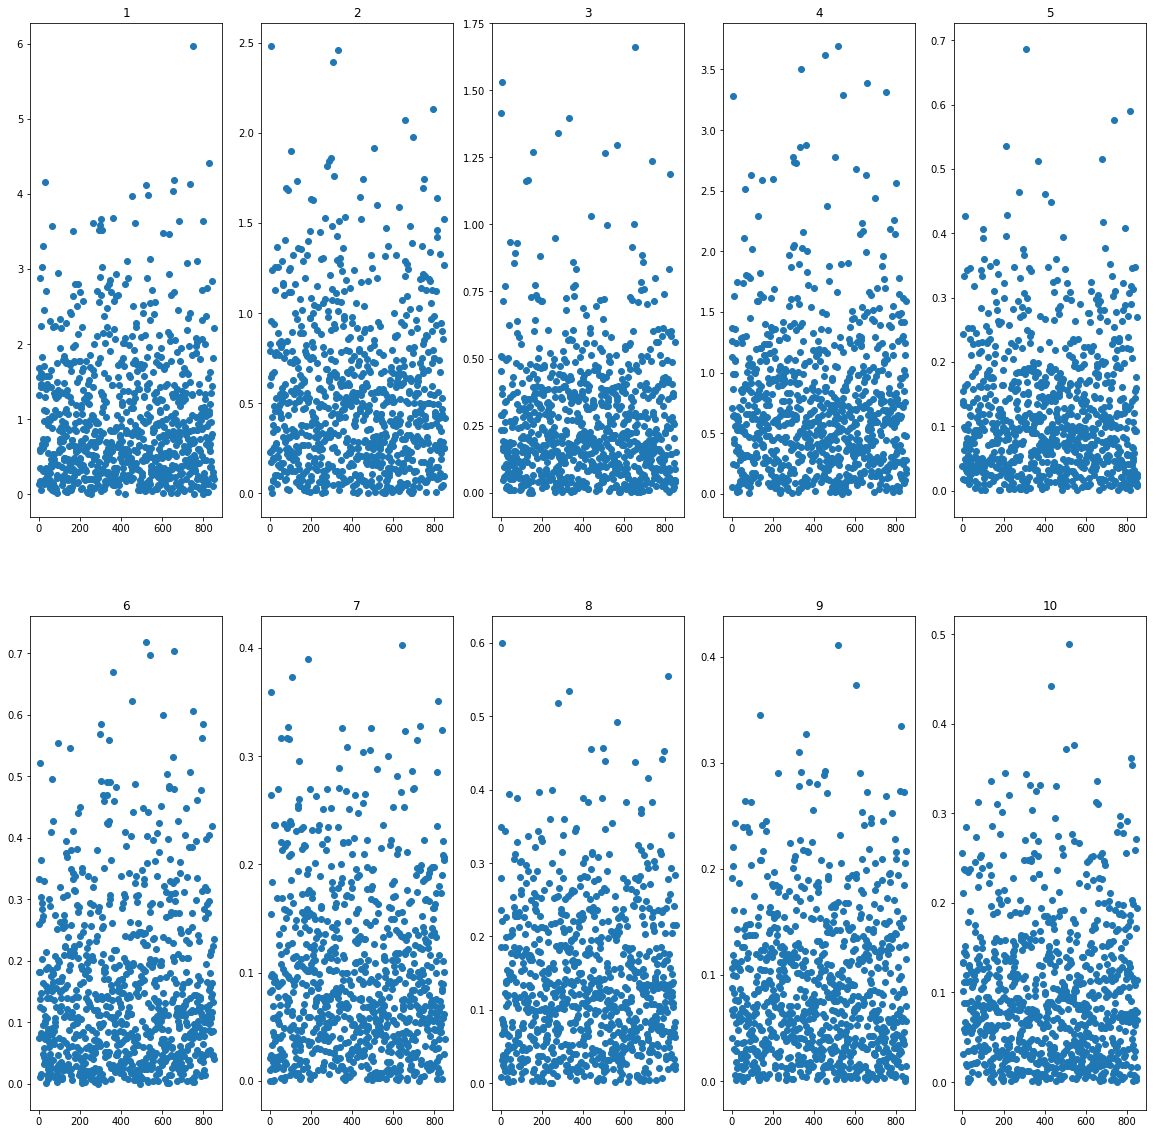

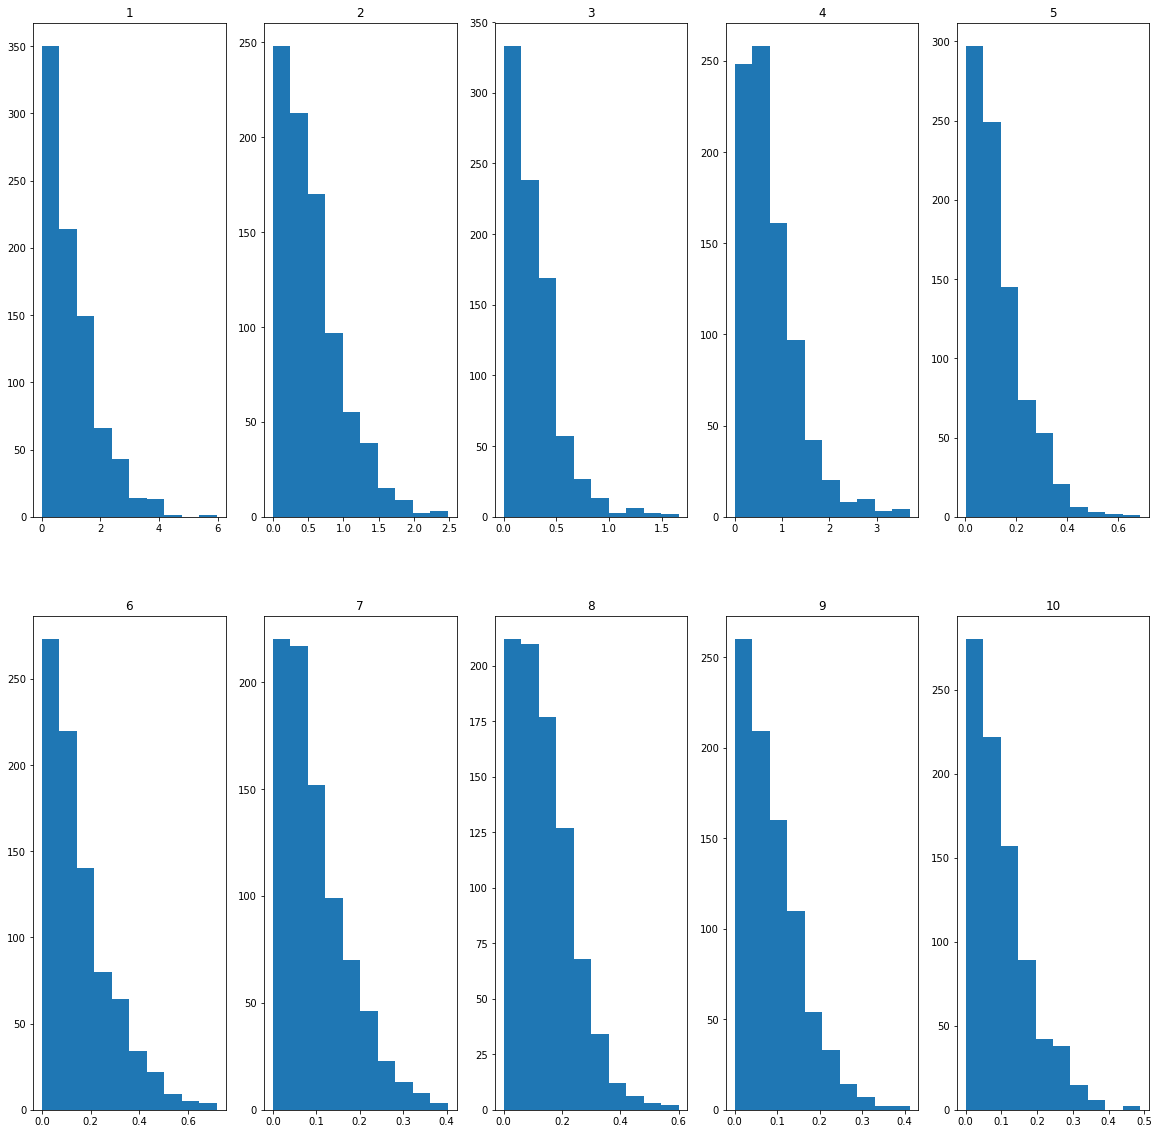

In [78]:
plt.figure(1,figsize=(20,20))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.title(i+1)
    plt.scatter(num,dif[:,i])
plt.show()
plt.figure(2,figsize=(20,20))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.title(i+1)
    plt.hist(dif[:,i])
plt.show()

In [79]:
for i in range(10):
    statistics(dif[:,i],str(i))

0 mean 1.0142202794251312 std 0.8755524676408981 max 5.97348363524378 min 0.003812009582956244
0 ptp 5.9696716256608235 median 0.7664781225499278 average 1.0142202794251312 var 0.766592123592066

1 mean 0.5396160100200251 std 0.4300053355403895 max 2.479895889271936 min 0.00041464590469730833
1 ptp 2.4794812433672386 median 0.4471888449023278 average 0.5396160100200251 var 0.18490458859320297

2 mean 0.2749102252362604 std 0.2362312836881937 max 1.661491771895638 min 0.0006949590505790637
2 ptp 1.6607968128450588 median 0.2143328640958108 average 0.2749102252362604 var 0.05580521939297185

3 mean 0.7517905328583128 std 0.6000812130032923 max 3.693974976382333 min 0.001684848518448634
3 ptp 3.6922901278638847 median 0.6293748182201049 average 0.7517905328583128 var 0.3600974621995027

4 mean 0.1250080486726859 std 0.10189059561731144 max 0.6863359565784162 min 0.0002065853944624163
4 ptp 0.6861293711839538 median 0.0982215161856008 average 0.1250080486726859 var 0.010381693475250486

5 

#### distributed

In [20]:
btmp = [[] for i in range(10)]
num = []
for i,key in enumerate(outputs):
    res = outputs[key]['res']
    for j in range(10):
        btmp[j].append(res[j])
    num.extend([i])

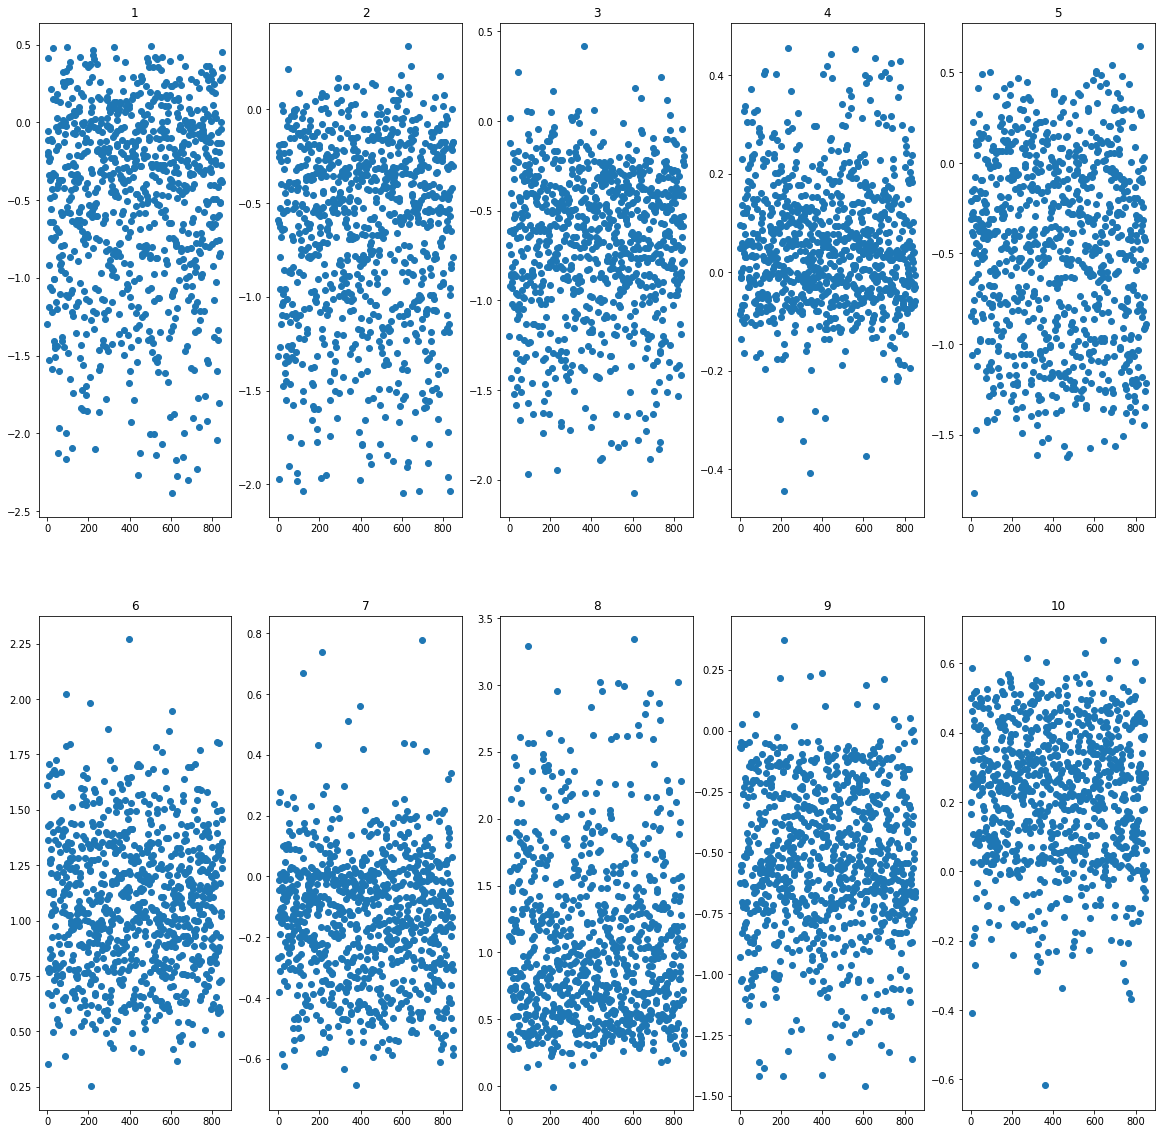

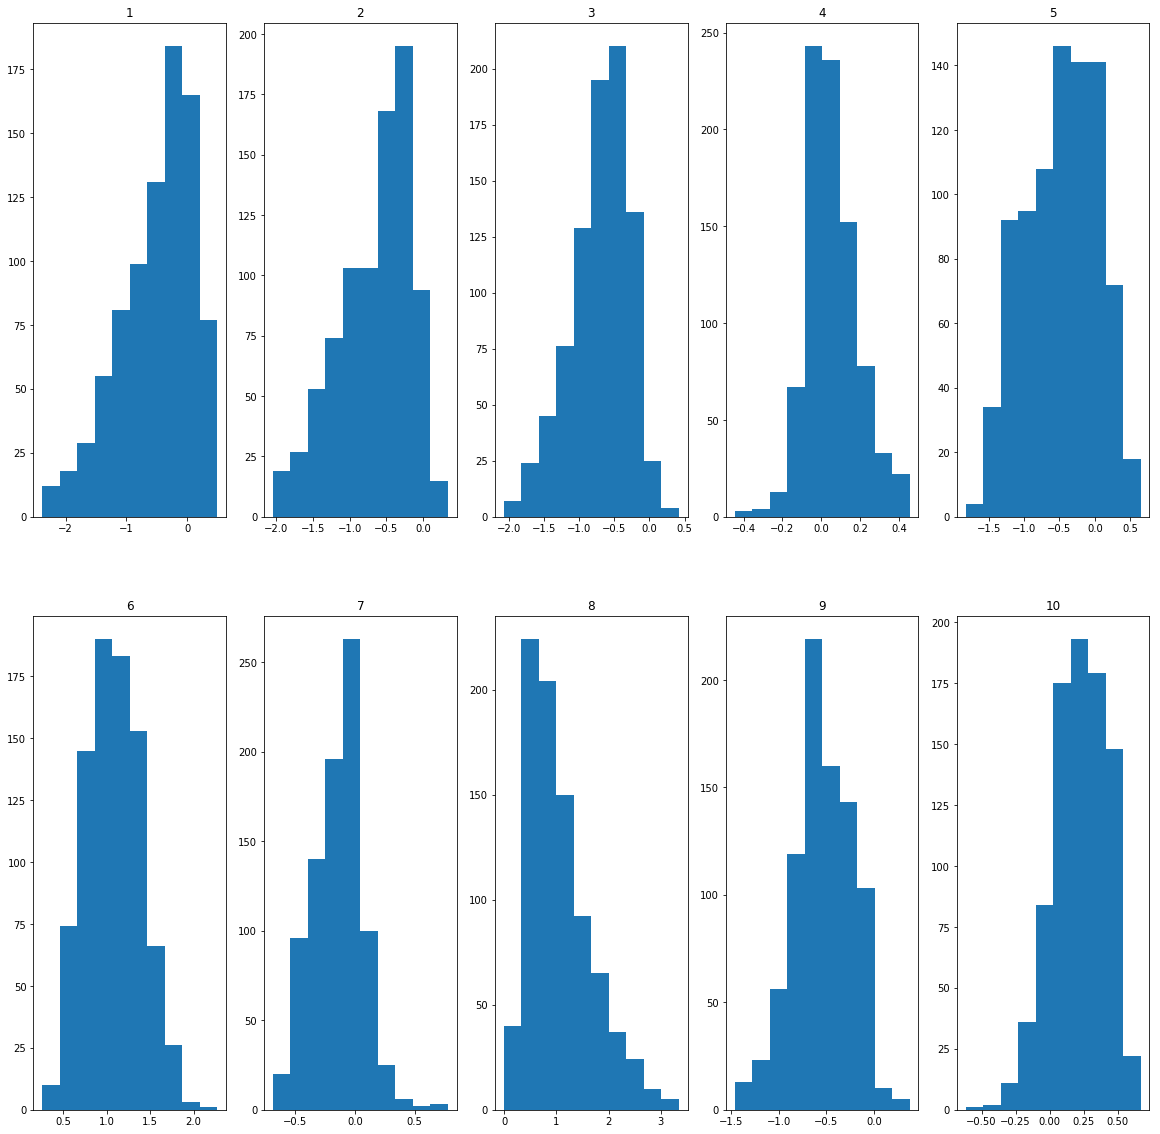

In [21]:
plt.figure(1,figsize=(20,20))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.title(i+1)
    plt.scatter(num,btmp[i])
plt.show()
plt.figure(2,figsize=(20,20))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.title(i+1)
    plt.hist(btmp[i])
plt.show()

In [21]:
def statistics(x, name = "no name"):
    print(name,"mean",np.mean(x),"std",np.std(x),"max",np.max(x),"min",np.min(x))
    print(name,"ptp",np.ptp(x),"median",np.median(x),"average",np.average(x),"var",np.var(x))
    print()

In [22]:
for i in range(10):
    statistics(btmp[i],str(i))

0 mean -0.7372445 std 1.7471677 max 0.06732729 min -12.891253
0 ptp 12.958581 median -0.09546062 average -0.7372445 var 3.052595

1 mean -0.4708822 std 1.271395 max 0.33265007 min -8.149666
1 ptp 8.482316 median 0.009880014 average -0.4708822 var 1.6164451

2 mean -1.4941922 std 3.0114818 max 0.2052991 min -20.085482
2 ptp 20.290781 median -0.2870903 average -1.4941922 var 9.069022

3 mean -0.5839549 std 1.3937443 max 0.2905726 min -8.645641
3 ptp 8.9362135 median -0.04306426 average -0.5839549 var 1.9425234

4 mean -0.0026271122 std 0.5036329 max 0.3149168 min -3.5889215
4 ptp 3.9038384 median 0.17196876 average -0.0026271122 var 0.25364608

5 mean 0.5992702 std 0.6636727 max 1.1384603 min -3.3723977
5 ptp 4.510858 median 0.8314253 average 0.5992702 var 0.4404614

6 mean -1.7132056 std 2.9076805 max -0.16176529 min -19.9573
6 ptp 19.795534 median -0.5641509 average -1.7132056 var 8.454606

7 mean 2.31615 std 2.0786414 max 14.995803 min 0.8390708
7 ptp 14.156733 median 1.4712878 averag

In [23]:
btmp = [[] for i in range(10)]
num = []
for i,key in enumerate(val_info):
    res = val_info[key]['betas']
    for j in range(10):
        btmp[j].append(res[j])
    num.extend([i])

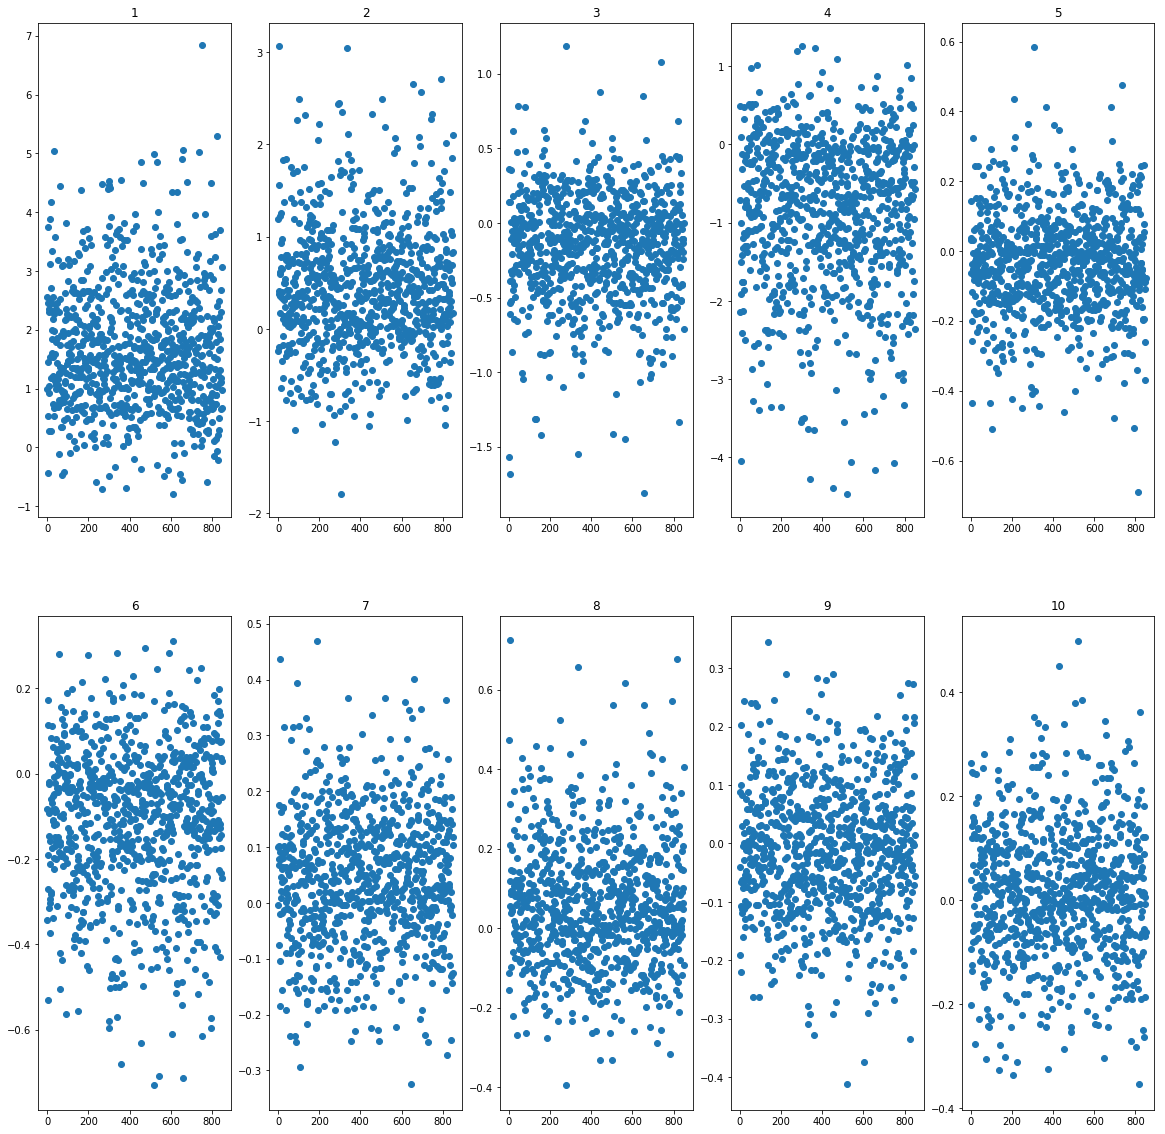

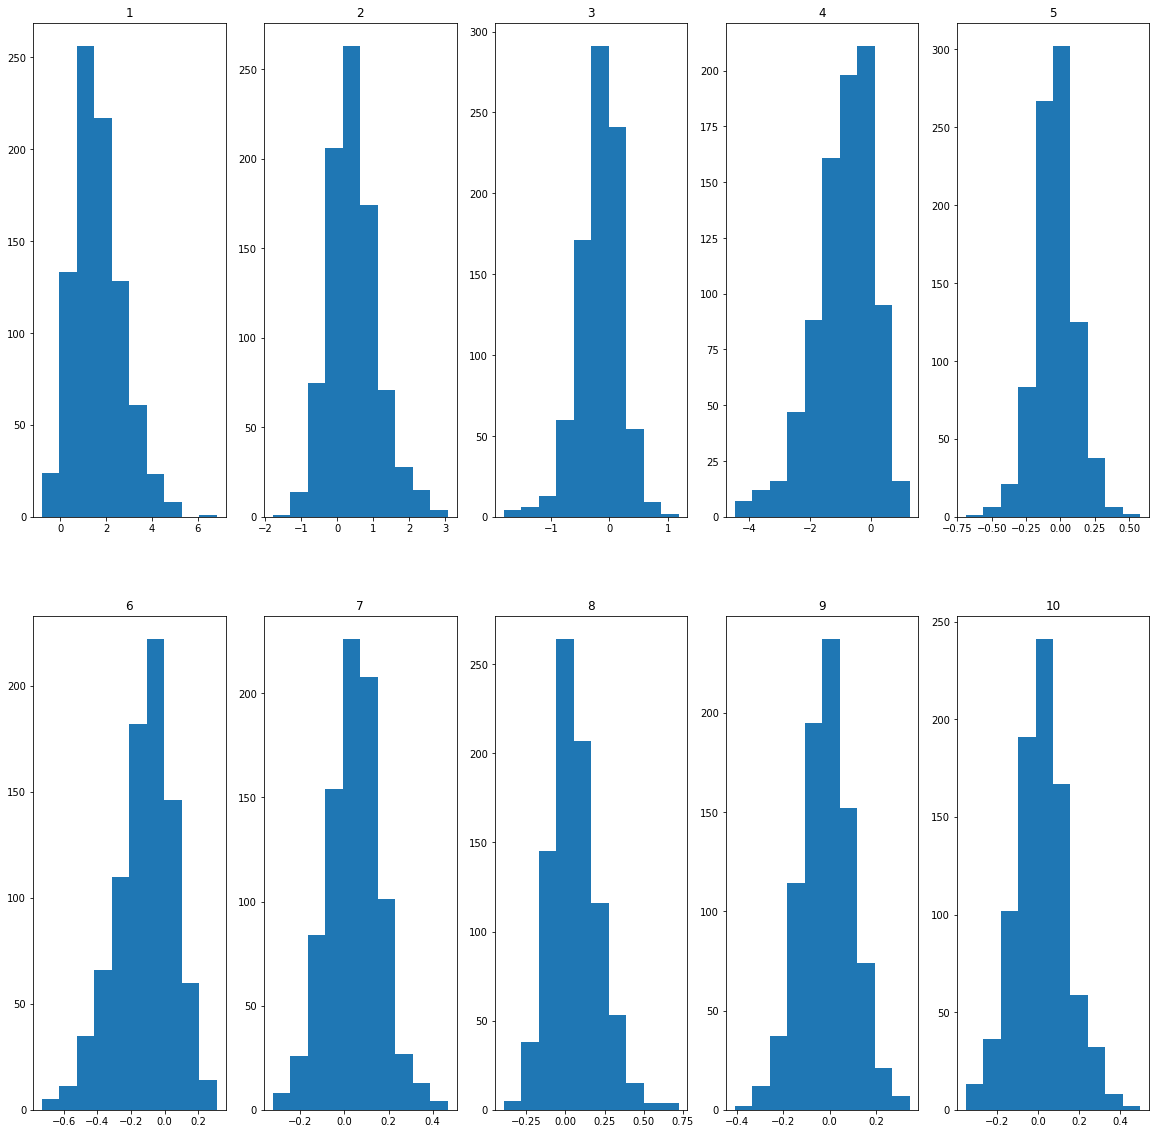

In [24]:
plt.figure(1,figsize=(20,20))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.title(i+1)
    plt.scatter(num,btmp[i])
plt.show()
plt.figure(2,figsize=(20,20))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.title(i+1)
    plt.hist(btmp[i])
plt.show()

In [25]:
for i in range(10):
    statistics(btmp[i],str(i))

0 mean 1.6834096682134712 std 1.0693325030583893 max 6.83752389079035 min -0.7911893933921759
0 ptp 7.628713284182526 median 1.5243632879117102 average 1.6834096682134712 var 1.1434720020971203

1 mean 0.4467790983900756 std 0.6731594828978823 max 3.0711319441692444 min -1.786185804546652
1 ptp 4.8573177487158965 median 0.3873650445663928 average 0.4467790983900756 var 0.4531436894153443

2 mean -0.1569837536113475 std 0.3622725376572257 max 1.186401443179316 min -1.8128653966972736
2 ptp 2.9992668398765896 median -0.12480049491885051 average -0.1569837536113475 var 0.13124139154060602

3 mean -0.863101875604825 std 0.9568253415525596 max 1.2629266584840686 min -4.465189699969369
3 ptp 5.728116358453438 median -0.713551691724613 average -0.863101875604825 var 0.9155147342371723

4 mean -0.03340275474728815 std 0.14624420487612239 max 0.5838716830064481 min -0.6906274054351683
4 ptp 1.2744990884416163 median -0.03198447948578532 average -0.03340275474728815 var 0.02138736745984926

5 me